# DBTL1: Filter recommendations
In `art_modeling_and_recommend_DBTL1.ipynb` we generated ART predictions of all possible combinations of up to 5 different CRISPRi gRNAs. 

In `analyze_recs_DBTL1.ipynb` we analyzed the recommendations.

Here, we will define a filtering strategy for the recommendations and use it to generate recommendations for DBTL2.

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

In [2]:
import os
import sys
from pathlib import Path
art_path = '../../art/'
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append(art_path)
import warning_utils
warning_utils.filter_end_user_warnings()

import copy
from IPython.display import Image  # Used to display images
import cloudpickle

from art.core import RecommendationEngine
import art.utility as utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import resource
# Convert 4GB to bytes
memory_limit = 16 * 1024 * 1024 * 1024

# Set the memory limit
resource.setrlimit(resource.RLIMIT_DATA, (memory_limit, memory_limit))

In [4]:
fig_loc = './dbtl1_figures_and_analysis_filter/'

## 1 Import `rec_df`, `data_df`, and trained ART model.

Import recommendation dataframe

In [5]:
rec_df = pd.read_pickle('./dbtl1_figures_and_analysis/DBTL1_rec_df_filtered_training_data.pkl')

In [6]:
# rec_df.head(3)

Sort `rec_df` and take a small subset from the top of the dataframe.

In [7]:
rec_df = rec_df.sort_values(by = 'pp_mean', ascending = False).iloc[:500000,:]

Get the columns related to gRNA (perturbations) from the recs.

In [8]:
pert_columns = rec_df.columns[:-2]

Dataframe of training data

In [9]:
data_df = pd.read_pickle(f'./dbtl1_figures_and_analysis/dbtl0_dbtl1_isoprenol_processed_df.pkl')

In [10]:
data_df.head(3)

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep,line_name_art
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,1,Control-R1
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,2,Control-R2
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,3,Control-R3


### 1.1 Add information to `rec_df`
Since we generated recs for all possible combinations of gRNA, some of the recs are in the experimental data. It would be useful to check if recommendations are in the experimental data or not.

First, add a `number_of_grna` column to recommendations to make them easier to filter.

In [11]:
rec_df['number_of_grna'] = rec_df.loc[:, pert_columns].apply(sum, axis = 1).astype(int)

Add indicator column to `rec_df`

In [12]:
rec_df['in_expt'] = 0

Iterate through rows of experimental data (since there is less of it)

In [13]:
for idx, expt_row in data_df.iterrows():
    n_grna_expt = expt_row['number_of_grna']
    rec_df_subset = rec_df[rec_df['number_of_grna']==n_grna_expt]
    
    matching_subset_index = np.where(np.all(rec_df_subset.loc[:, pert_columns] == expt_row[pert_columns], axis = 1))
    assert len(matching_subset_index)==1, 'ERROR: experimental data missing from recommendations'
    rec_df_index = rec_df_subset.iloc[matching_subset_index[0],:].index
    rec_df.loc[rec_df_index, 'in_expt'] = int(1)

In [14]:
rec_df = rec_df[rec_df['in_expt'] == 0]

In [15]:
rec_df[rec_df['in_expt'] == 1]['number_of_grna'].value_counts()

Series([], Name: count, dtype: int64)

In [16]:
data_df

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene,pass_to_art,cumulative_rep,line_name_art
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,1,Control-R1
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,2,Control-R2
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,3,Control-R3
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,4,Control-R4
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],...,0,0,0,0,0,0,False,1,5,Control-R5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,PP_0437_PP_3365-R3,DBTL1_P4_044,mg/L,247.03410,3,PP_0437_PP_3365,None,1,False,"[PP_0437, PP_3365]",...,0,0,0,0,0,0,True,1,3,PP_0437_PP_3365-R3
593,PP_1319_PP_4121_PP_4667-R3,DBTL1_P4_045,mg/L,208.59250,3,PP_1319_PP_4121_PP_4667,None,1,False,"[PP_1319, PP_4121, PP_4667]",...,0,0,0,0,0,0,True,1,3,PP_1319_PP_4121_PP_4667-R3
594,PP_0814_PP_4192-R3,DBTL1_P4_046,mg/L,328.09770,3,PP_0814_PP_4192,None,1,False,"[PP_0814, PP_4192]",...,0,0,0,0,0,0,True,False,3,PP_0814_PP_4192-R3
595,PP_0812_PP_4121-R3,DBTL1_P4_047,mg/L,294.92530,3,PP_0812_PP_4121,None,1,False,"[PP_0812, PP_4121]",...,0,0,0,0,0,0,True,False,3,PP_0812_PP_4121-R3


In [17]:
data_df[data_df['has_cycle1_gene']]['number_of_grna'].value_counts()

number_of_grna
1    192
3     90
2     90
Name: count, dtype: int64

## 2. Filter recs and save final recs for DBTL2
Define the following variables:

- `N_total_recs`: The total number of recommendations.
- `N_grna_dict`: A dictionary defining how many recommendations of each length are requrested. Entries are formatted as {number of gRNA: number of recs}. 
- `max_grna_appearances`: A number controlling how many times a single guide RNA can show up in the recommendations.

Create an indicator column for whether a candidate recommendation should be kept.

In [18]:
rec_df['to_rec'] = 0

### 2.1 Define functions to identify recommendations
We will iterate through `rec_df` and selectively identify candidate recommendations to keep.

In [19]:
write_line_name = lambda x: '_'.join(pert_columns[np.where(x == 1)])

In [20]:
n_total_recs = 60
n_grna_dict = {0: 0,
               1: 0,
               2: 25,
               3: 30,
               4: 5,
               5: 0}

assert sum(n_grna_dict.values()) == n_total_recs, "Number of total recs should equal the num of N_gRNA in N_grna_dict"

max_grna_appearances = 15

Create variables to track how many of each gRNA length we've added, and how many of each gRNA.

Then, iterate through rec_df. At each iteration:

1. Get the number of gRNA and the gRNA identities of the current candidate.
2. Check how many recommendations already have the number of gRNA and gRNA identities of current candidate.
3. If the current recommendation is allowed (doesn't exceed the number of gRNA lengths or gRNA appearances), change `rec_df['to_rec']` to 1.

End loop once the required number of reqs (`n_total_recs`) is reached.

In [21]:
grna_len_tracker = {0: 0,
                    1: 0,
                    2: 0,
                    3: 0,
                    4: 0,
                    5: 0}
grna_tracker = dict(zip(pert_columns.values, [0 for i in range(len(pert_columns))]))
n_recs_added = 0
n_recs_skipped = 0
rec_list = []
for rec_idx, rec_data in rec_df.iterrows():
    #Get values to check whether to keep this rec
    current_grna_length = rec_data['number_of_grna']
    current_grna = pert_columns[np.where(rec_data[pert_columns] == 1)].values

    #Get values from trackers for recommendations and recommendation lengths
    already_recommended_grna = np.array([grna_tracker[grna] for grna in current_grna])
    already_recommended_lengths = grna_len_tracker[current_grna_length]
    
    # print(f'Already recommended grna: {already_recommended_grna}\t already recommended lengths: {already_recommended_lengths}')
    
    if np.any(already_recommended_grna>=max_grna_appearances) or already_recommended_lengths>=n_grna_dict[current_grna_length]:
        n_recs_skipped += 1
    else:
        print(f'\nadding rec: {rec_idx}')
        print(f'Rec Idx: {rec_idx}\tCurrent grna: {current_grna}\tCurrent grna length: {current_grna_length}')
        print(f'Already recommended grna: {already_recommended_grna}\t already recommended lengths: {already_recommended_lengths}')

        rec_df.loc[rec_idx, 'to_rec'] = 1
        grna_len_tracker[current_grna_length] += 1
        for current_single_grna in current_grna:
            grna_tracker[current_single_grna] += 1
        n_recs_added+=1
        rec_list.append(list(current_grna))
        print(rec_list)
        print('\n')
    if n_recs_added >= n_total_recs:
        print('Number of total recs reached, breaking')
        print('~~~~~~~~~~~~~~~~~~~~~')
        break
        
print(f'Number of skipped candidates: {n_recs_skipped}\t Number of added candidates: {n_recs_added}')


adding rec: 118077
Rec Idx: 118077	Current grna: ['PP_0528' 'PP_0815' 'PP_1317' 'PP_4191']	Current grna length: 4.0
Already recommended grna: [0 0 0 0]	 already recommended lengths: 0
[['PP_0528', 'PP_0815', 'PP_1317', 'PP_4191']]



adding rec: 112467
Rec Idx: 112467	Current grna: ['PP_0528' 'PP_0751' 'PP_0815' 'PP_1317']	Current grna length: 4.0
Already recommended grna: [1 0 1 1]	 already recommended lengths: 1
[['PP_0528', 'PP_0815', 'PP_1317', 'PP_4191'], ['PP_0528', 'PP_0751', 'PP_0815', 'PP_1317']]



adding rec: 115852
Rec Idx: 115852	Current grna: ['PP_0528' 'PP_0813' 'PP_0815' 'PP_1317']	Current grna length: 4.0
Already recommended grna: [2 0 2 2]	 already recommended lengths: 2
[['PP_0528', 'PP_0815', 'PP_1317', 'PP_4191'], ['PP_0528', 'PP_0751', 'PP_0815', 'PP_1317'], ['PP_0528', 'PP_0813', 'PP_0815', 'PP_1317']]



adding rec: 118054
Rec Idx: 118054	Current grna: ['PP_0528' 'PP_0815' 'PP_1317' 'PP_1769']	Current grna length: 4.0
Already recommended grna: [3 3 3 0]	 alread

In [22]:
assert rec_df['to_rec'].sum() == n_total_recs, 'ERROR: incorrect number of recommendations'

### 2.2 Create dataframe for filtered recs

In [23]:
filtered_recs = rec_df[rec_df['to_rec'] == 1].copy()

Add human-readable line name to recs_df

In [24]:
filtered_recs['line_name'] = filtered_recs.loc[:,pert_columns].apply(write_line_name, axis = 1)

In [25]:
filtered_recs.head(5)

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,to_rec,line_name
118077,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,522.647032,75.405264,4,0,1,PP_0528_PP_0815_PP_1317_PP_4191
112467,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,512.640343,73.305519,4,0,1,PP_0528_PP_0751_PP_0815_PP_1317
115852,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,505.477196,71.580319,4,0,1,PP_0528_PP_0813_PP_0815_PP_1317
118054,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,502.332123,71.533489,4,0,1,PP_0528_PP_0815_PP_1317_PP_1769
116887,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,496.568803,73.066223,4,0,1,PP_0528_PP_0814_PP_0815_PP_1317


### 2.3 Plot gRNA identities and distributions for each recommendation

Import trained ART model:

In [26]:
art_path = './dbtl1_art_outputs/art.cpkl'
with open(art_path, 'rb') as art_file:
    art = cloudpickle.load(art_file)

Define function to plot distributions

In [27]:
def plot_draws(preds, feature_columns, prev_max = None, title_text = None, figsize = (6,6)):
    
    fig, ax = plt.subplots(figsize = figsize)
    draws = art.post_pred_draws(preds.loc[:,feature_columns], n_samples = 1000)[0]
    draws_df = pd.DataFrame(data = draws, columns = preds['line_name'])
    draws_df = pd.melt(draws_df, value_vars= preds['line_name'], value_name = 'titer', var_name = 'Line Name')

    pal = sns.cubehelix_palette(10, rot=-0.45, start=0.0, dark=0.3, light=0.7, reverse=True)
    sns.violinplot(draws_df, y = 'Line Name', x = 'titer', palette = pal, ax = ax, ) #split = True)
    if prev_max is not None:
        ax.axvline(prev_max, color = 'k', linestyle = '--', linewidth = 0.5)
    if title_text is not None:
        ax.set_title(title_text)    
    return fig

Sampling: [y]
Sampling: [y]


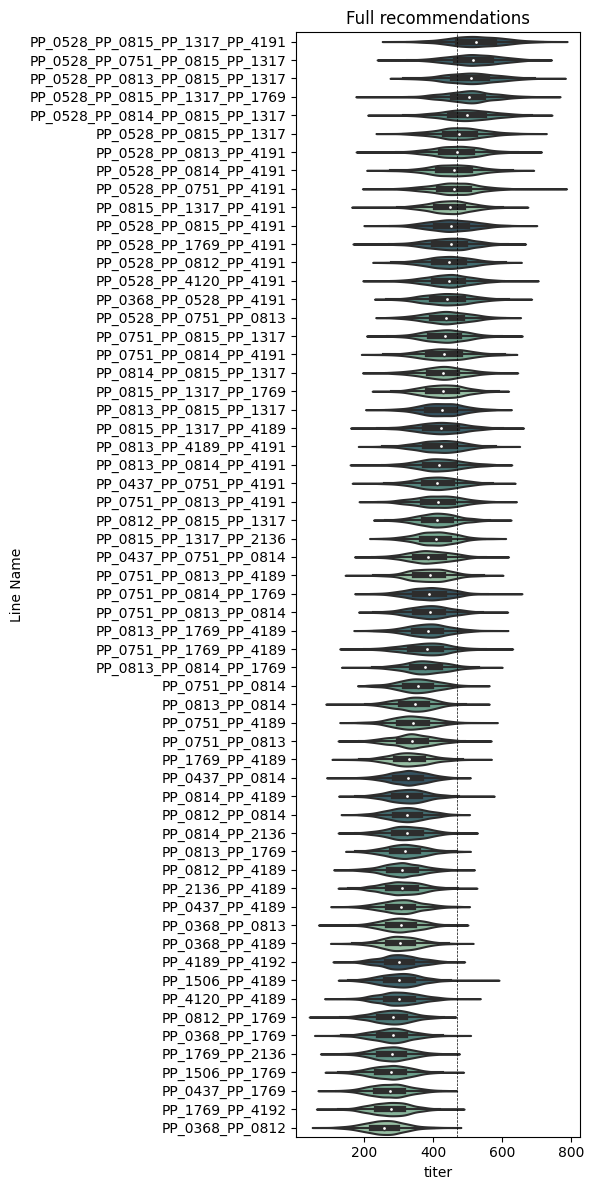

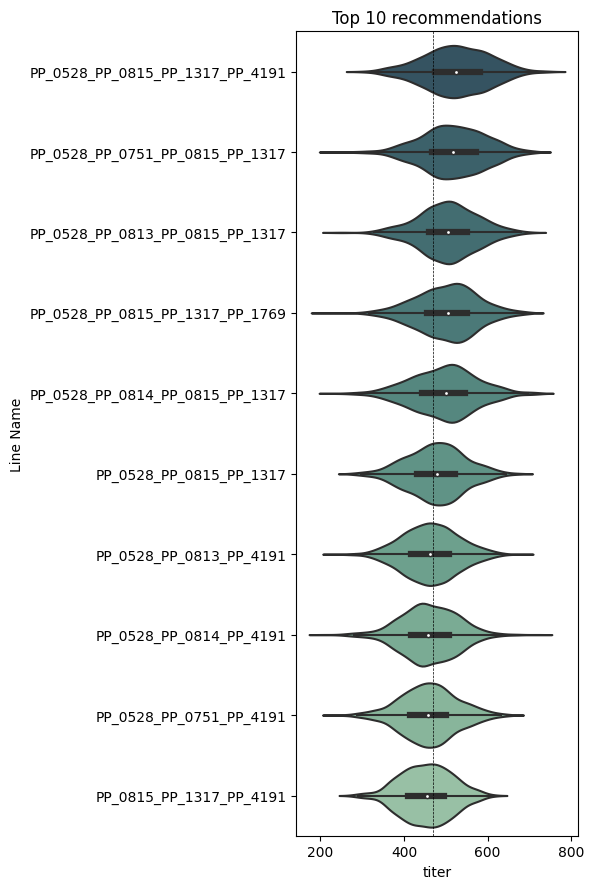

In [28]:
fig = plot_draws(filtered_recs,
                 feature_columns=pert_columns,
                 prev_max = data_df['isoprenol'].max(),
                 title_text = 'Full recommendations',
                 figsize = (6, 12))
fig.tight_layout()

fig.savefig(fig_loc + '/filtered_recs_draws_allrecs.png')

fig = plot_draws(filtered_recs.iloc[:10,:], 
                 feature_columns=pert_columns,
                 prev_max = data_df['isoprenol'].max(),
                 title_text = 'Top 10 recommendations',
                 figsize = (6, 9))
fig.tight_layout()

fig.savefig(fig_loc + '/filtered_recs_draws_top10recs.png')


In [29]:
grna_count = np.sum(filtered_recs.loc[:, pert_columns], axis = 0)
grna_count_df = pd.DataFrame(data = grna_count)
grna_count_df = grna_count_df.reset_index()
grna_count_df=grna_count_df.rename(columns={grna_count_df.columns.values[1]:'counts', 'index':'grna'})


Plot and format the counts datafame

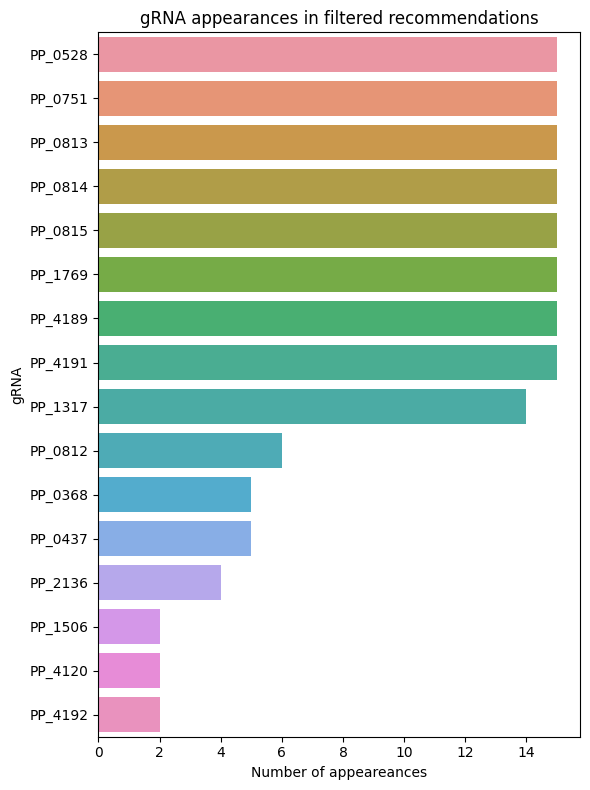

In [30]:
fig, ax = plt.subplots(figsize = (6,8))
sns.barplot(grna_count_df[grna_count_df['counts'] >0].sort_values(by = 'counts', ascending = False), x = 'counts', y = 'grna', ax = ax)
ax.set_title(f'gRNA appearances in filtered recommendations')
ax.set_xlabel('Number of appeareances')
ax.set_ylabel('gRNA')
fig.tight_layout()
fig.savefig(f'{fig_loc}gRNA_appearances_in_filtered_recs.png')

### 2.4 Save final recommendation as a dataframe

In [31]:
filtered_recs_export = filtered_recs.drop(columns=pert_columns)

In [32]:
filtered_recs

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna,in_expt,to_rec,line_name
118077,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,522.647032,75.405264,4,0,1,PP_0528_PP_0815_PP_1317_PP_4191
112467,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,512.640343,73.305519,4,0,1,PP_0528_PP_0751_PP_0815_PP_1317
115852,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,505.477196,71.580319,4,0,1,PP_0528_PP_0813_PP_0815_PP_1317
118054,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,502.332123,71.533489,4,0,1,PP_0528_PP_0815_PP_1317_PP_1769
116887,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,496.568803,73.066223,4,0,1,PP_0528_PP_0814_PP_0815_PP_1317
6456,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,476.639634,65.961624,3,0,1,PP_0528_PP_0815_PP_1317
6395,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,463.234349,65.892138,3,0,1,PP_0528_PP_0813_PP_4191
6441,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,460.076350,67.529320,3,0,1,PP_0528_PP_0814_PP_4191
6251,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,458.107585,65.815754,3,0,1,PP_0528_PP_0751_PP_4191
15892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,451.674091,61.612117,3,0,1,PP_0815_PP_1317_PP_4191


In [33]:
filtered_recs_export
column_reorder = ['line_name', 'pp_mean', 'pp_std', 'number_of_grna', 'in_expt', 'to_rec']
filtered_recs_export = filtered_recs_export[column_reorder]
filtered_recs_export

,line_name,pp_mean,pp_std,number_of_grna,in_expt,to_rec
118077,PP_0528_PP_0815_PP_1317_PP_4191,522.647032,75.405264,4,0,1
112467,PP_0528_PP_0751_PP_0815_PP_1317,512.640343,73.305519,4,0,1
115852,PP_0528_PP_0813_PP_0815_PP_1317,505.477196,71.580319,4,0,1
118054,PP_0528_PP_0815_PP_1317_PP_1769,502.332123,71.533489,4,0,1
116887,PP_0528_PP_0814_PP_0815_PP_1317,496.568803,73.066223,4,0,1
6456,PP_0528_PP_0815_PP_1317,476.639634,65.961624,3,0,1
6395,PP_0528_PP_0813_PP_4191,463.234349,65.892138,3,0,1
6441,PP_0528_PP_0814_PP_4191,460.076350,67.529320,3,0,1
6251,PP_0528_PP_0751_PP_4191,458.107585,65.815754,3,0,1
15892,PP_0815_PP_1317_PP_4191,451.674091,61.612117,3,0,1


In [34]:
filtered_recs_export.to_csv(fig_loc + 'filtered_recs_for_dbtl2.csv')